In [ ]:
import gzip
import json
import dateutil.parser
import random
import numpy as np
from collections import defaultdict
import pandas as pd
from datetime import datetime
import re

In [4]:
def parse(path):
 g = gzip.open(path, 'r')
 for l in g:
   yield eval(l)
   
aussie_reviews = []

In [5]:
for r in parse("australian_user_reviews.json.gz"):
   aussie_reviews.append(r)
len(aussie_reviews)

25799

In [6]:
user_item_rows = []   # (user_id, item_id, playtime)


for user in parse("australian_users_items.json.gz"):
   uid = user["user_id"]
   for it in user["items"]:
       user_item_rows.append(
           (uid, it["item_id"], it["playtime_forever"])
       )


len(user_item_rows), user_item_rows[:5]


(5153209,
 [('76561197970982479', '10', 6),
  ('76561197970982479', '20', 0),
  ('76561197970982479', '30', 7),
  ('76561197970982479', '40', 0),
  ('76561197970982479', '50', 0)])

In [7]:
games = {}


for game in parse("steam_games.json.gz"):
   # Detect the correct ID column
   gid = (
       game.get("app_id") or
       game.get("product_id") or
       game.get("steam_appid") or
       game.get("appid") or
       game.get("id")
   )


   if gid is None:
       continue  # skip malformed rows
  
   games[str(gid)] = game


len(games)


32132

# Phase 1: Data Preprocessing and Feature Engineering

## Step 1.1: Data Cleaning & Unpacking for steam_games.json


In [ ]:
# Step 1.1: Clean and enrich steam_games.json

def normalize_price(price):
    """Normalize price field: convert 'Free To Play' to 0.00, handle other string prices"""
    if price is None:
        return 0.0
    if isinstance(price, (int, float)):
        return float(price)
    if isinstance(price, str):
        price_lower = price.lower().strip()
        if 'free' in price_lower or price_lower == '':
            return 0.0
        try:
            numbers = re.findall(r'\d+\.?\d*', price)
            if numbers:
                return float(numbers[0])
            return 0.0
        except:
            return 0.0
    return 0.0

def normalize_release_date(release_date):
    """Normalize release_date to datetime object for time-series analysis"""
    if release_date is None or release_date == '':
        return None
    if isinstance(release_date, str):
        try:
            return dateutil.parser.parse(release_date)
        except:
            return None
    return None

games_list = []

for game in parse("steam_games.json.gz"):
    # Detect the correct ID column
    gid = (
        game.get("app_id") or
        game.get("product_id") or
        game.get("steam_appid") or
        game.get("appid") or
        game.get("id")
    )
    
    if gid is None:
        continue  
    
    title = game.get("title") or game.get("app_name") or ""
    
    genres = game.get("genres", [])
    if not isinstance(genres, list):
        genres = []
    
    developer = game.get("developer", "")
    if isinstance(developer, list):
        developer = ", ".join(developer) if developer else ""
    elif developer is None:
        developer = ""
    
    # Normalize price
    price = normalize_price(game.get("price", 0.0))
    
    release_date = normalize_release_date(game.get("release_date"))
    
    games_list.append({
        'game_id': str(gid),
        'title': title,
        'genres': genres,
        'developer': developer,
        'price': price,
        'release_date': release_date
    })

games_df = pd.DataFrame(games_list)

print(f"Total games processed: {len(games_df)}")
print(f"\nGames DataFrame shape: {games_df.shape}")
print(f"\nFirst few rows:")
print(games_df.head())
print(f"\nDataFrame info:")
print(games_df.info())
print(f"\nPrice statistics:")
print(games_df['price'].describe())
print(f"\nRelease date range:")
print(f"Earliest: {games_df['release_date'].min()}")
print(f"Latest: {games_df['release_date'].max()}")


## Step 1.2: Define Engagement Target for australian_users_items.json


In [ ]:
# Step 1.2: Define Engagement Target


user_game_interactions = []

for user in parse("australian_users_items.json.gz"):
    uid = user["user_id"]
    for item in user["items"]:
        item_id = item["item_id"]
        playtime_forever = item.get("playtime_forever", 0)
        
        is_played = 1 if playtime_forever > 0 else 0
        
        user_game_interactions.append({
            'user_id': uid,
            'item_id': str(item_id),
            'playtime_forever': playtime_forever,
            'is_played': is_played
        })

user_game_df = pd.DataFrame(user_game_interactions)

print(f"Total user-game interactions: {len(user_game_df)}")
print(f"\nUser-Game Interactions DataFrame shape: {user_game_df.shape}")
print(f"\nFirst few rows:")
print(user_game_df.head(10))
print(f"\nDataFrame info:")
print(user_game_df.info())
print(f"\nEngagement statistics:")
print(f"Total interactions: {len(user_game_df)}")
print(f"Games played (is_played=1): {user_game_df['is_played'].sum()} ({100*user_game_df['is_played'].sum()/len(user_game_df):.2f}%)")
print(f"Games not played (is_played=0): {(user_game_df['is_played']==0).sum()} ({100*(user_game_df['is_played']==0).sum()/len(user_game_df):.2f}%)")
print(f"\nPlaytime statistics:")
print(user_game_df['playtime_forever'].describe())


In [8]:
import numpy as np


X_rows = []
y_rows = []


for (uid, gid, playtime) in user_item_rows:
   if gid not in games:
       continue   # skip games missing metadata


   game = games[gid]


   # --- Label ---
   y = 1 if playtime > 0 else 0


   # --- Features ---
   genres = game.get("genres", [])
   price = game.get("price", 0.0)
   if type(price) != float:
       price = 0.0
  
   X_rows.append((genres, float(price)))
   y_rows.append(y)


In [9]:
from sklearn.preprocessing import MultiLabelBinarizer, StandardScaler
import numpy as np


# Extract genre lists + prices
genre_lists = [g for (g, p) in X_rows]
prices =       [p for (g, p) in X_rows]


# Fit one-hot encoder on genres
mlb = MultiLabelBinarizer()
genre_OH = mlb.fit_transform(genre_lists)


# Normalize price
scaler = StandardScaler()
price_scaled = scaler.fit_transform(np.array(prices).reshape(-1,1))


# Final X matrix
X = np.hstack([genre_OH, price_scaled])
y = np.array(y_rows)
X.shape, y.shape

((4294257, 22), (4294257,))

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression


X_train, X_test, y_train, y_test = train_test_split(
   X, y, test_size=0.2, random_state=42
)


clf = LogisticRegression(max_iter=2000)
clf.fit(X_train, y_train)


LogisticRegression(max_iter=2000)

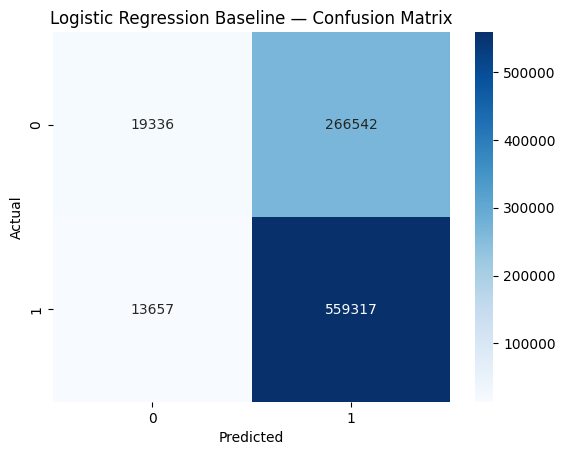

Precision: 0.6772548340576297
Recall: 0.9761647125349492


In [11]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score
import seaborn as sns
import matplotlib.pyplot as plt


y_pred = clf.predict(X_test)


cm = confusion_matrix(y_test, y_pred)


sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Logistic Regression Baseline — Confusion Matrix")
plt.show()


print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
